In this notebook, I will train and test my custom SRL model on the noUniteD-SRL dataset, generated using the sentences in the MAVEN dataset.

# Prerequisites

In [1]:
import os, sys

import numpy as np
import tqdm
import torch

/home/marco/miniconda3/envs/nuans_minihw2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Important paths for the notebook:

In [2]:
datasets_root_path = './datasets/'
srl_dataset_path = os.path.join(datasets_root_path, 'maven_nounited_srl')
checkpoints_dir_path = './checkpoints/'
model_dir_path = os.path.join(checkpoints_dir_path, 'models_nounited_maven')

srl_dataset_dict_paths = {}
for lang in os.listdir(srl_dataset_path):
    dataset_lang_path = os.path.join(srl_dataset_path, lang)
    if os.path.isdir(dataset_lang_path):
        srl_dataset_dict_paths[lang] = {}
        for d_type in os.listdir(dataset_lang_path):
            d_name = d_type.split('.')[0]
            srl_dataset_dict_paths[lang][d_name] = os.path.join(dataset_lang_path, d_type)

In [3]:
%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [4]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
global_params = {
    'batch_size': 32,
    'transformer_name': "xlm-roberta-base",
}

In [6]:
from code_files.datasets.dataset_nounited import DatasetNoUniteD

## Training the Predicate Identification and Disambiguation model with only verbal predicates

In [7]:
split_type = '_v'

In [8]:
dataset_train_en_pid = DatasetNoUniteD(  srl_dataset_dict_paths['EN']['train'], split_predicates=False, split_type_to_use = split_type )
dataset_dev_en_pid = DatasetNoUniteD(  srl_dataset_dict_paths['EN']['dev'], split_predicates=False, split_type_to_use = split_type )

In [9]:
global_params.update({
    'n_roles_labels': len(dataset_train_en_pid.id_to_roles),
    'n_predicates_labels': len(dataset_train_en_pid.id_to_predicates),

    'id_to_roles': dataset_train_en_pid.id_to_roles,
    'roles_to_id': dataset_train_en_pid.roles_to_id,
    'roles_pad_id': dataset_train_en_pid.roles_pad_id,
    'roles_pad': dataset_train_en_pid.roles_pad,

    'id_to_predicates': dataset_train_en_pid.id_to_predicates,
    'predicates_to_id': dataset_train_en_pid.predicates_to_id,
    'predicates_pad_id': dataset_train_en_pid.predicates_pad_id,
    'predicates_pad': dataset_train_en_pid.predicates_pad,
})

In [10]:
np.save(os.path.join(model_dir_path, 'global_params.npy'), global_params)

In [11]:
len(dataset_train_en_pid.data), len(dataset_dev_en_pid.data)

(24575, 6143)

In [27]:
print(dataset_train_en_pid[0],'\n\n',dataset_dev_en_pid[0])

{'words': ['The', '2006', 'Pangandaran', 'earthquake', 'and', 'tsunami', 'occurred', 'on', 'July', '17', 'at', 'along', 'a', 'subduction', 'zone', 'off', 'the', 'coast', 'of', 'west', 'and', 'central', 'Java', ',', 'a', 'large', 'and', 'densely', 'populated', 'island', 'in', 'the', 'Indonesian', 'archipelago', '.'], 'predicates': ['_', '_', '_', 'MOVE-ONESELF', '_', '_', 'HAPPEN_OCCUR', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 'predicates_v': ['_', '_', '_', '_', '_', '_', 'HAPPEN_OCCUR', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 'predicates_n': ['_', '_', '_', 'MOVE-ONESELF', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 'roles': {'6': ['_', '_', '_', 'Theme', '_', '_', '_', '_', '

In [29]:
from torch.utils.data import DataLoader

dataloader_train_en_pid = DataLoader(
    dataset_train_en_pid,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_en_pid.create_collate_fn(), # verbal predicates only!
    shuffle=True,
)

dataloader_dev_en_pid = DataLoader(
    dataset_dev_en_pid,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_en_pid.create_collate_fn(), # verbal predicates only!
    shuffle=False,
)

In [30]:
for e in dataloader_dev_en_pid:
    ex_in = e
    break

In [31]:
smpl = 1
print(
    ex_in['words'][smpl], '\n', 
    ex_in['predicates'][smpl], '\n', 
    ex_in['predicates_positions'][smpl])

['Since', '1916', 'the', 'anniversary', 'of', 'the', 'landings', 'on', '25', 'April', 'has', 'been', 'commemorated', 'as', 'Anzac', 'Day', ',', 'becoming', 'one', 'of', 'the', 'most', 'important', 'national', 'celebrations', 'in', 'Australia', 'and', 'New', 'Zealand', '.'] 
 ['_', '_', '_', '_', '_', '_', 'LAND_GET-OFF', '_', '_', '_', '_', '_', 'CELEBRATE_PARTY', '_', '_', '_', '_', 'CHANGE_SWITCH', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'] 
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [32]:
loss_function_pid = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en_pid.predicates_pad_id) # !

In [33]:
from code_files.models.model_pid import ModelPID
from code_files.utils.utils_functions import print_summary
import torch.optim as optim

model_pid = ModelPID(
    loss_fn = loss_function_pid,
    hparams = global_params,
    fine_tune_transformer = True,
    has_predicates_positions = False # it does both pred iden and disamb
)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
optimizer_pid = optim.SGD(model_pid.parameters(), lr=0.0016, momentum=0.9) 

In [34]:
print_summary(model_pid, short=True)

parameters: 278,376,625
trainable parameters: 278,376,625
non-trainable parameters: 0


In [36]:
history = {}

In [37]:
from code_files.utils.Trainer_pid import Trainer_pid

trainer_pid = Trainer_pid()

history = trainer_pid.train(
    model_pid, optimizer_pid, dataloader_train_en_pid, dataloader_dev_en_pid,
    epochs=100, device=device,
    save_best=True, 
    min_score=0.8,
    save_path_name=os.path.join(model_dir_path, f'pid_transformer_nounited{split_type}.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.598859
# Validation loss => 0.443899 | f1-score: pred_iden = 0.974307 pred_dis = 0.036807 #
Epoch   1 => avg_loss: 0.480728
# Validation loss => 0.426709 | f1-score: pred_iden = 0.967008 pred_dis = 0.060702 #
Epoch   2 => avg_loss: 0.460709
# Validation loss => 0.388203 | f1-score: pred_iden = 0.975223 pred_dis = 0.172881 #
Epoch   3 => avg_loss: 0.438106
# Validation loss => 0.310577 | f1-score: pred_iden = 0.971932 pred_dis = 0.323223 #
Epoch   4 => avg_loss: 0.344255
# Validation loss => 0.230077 | f1-score: pred_iden = 0.969906 pred_dis = 0.532493 #
Epoch   5 => avg_loss: 0.282388
# Validation loss => 0.178841 | f1-score: pred_iden = 0.979803 pred_dis = 0.624212 #
Epoch   6 => avg_loss: 0.231131
# Validation loss => 0.144209 | f1-score: pred_iden = 0.982354 pred_dis = 0.694810 #
Epoch   7 => avg_loss: 0.194130
# Validation loss => 0.118256 | f1-score: pred_iden = 0.982223 pred_dis = 0.752963 #
Epoch   8 => avg_loss: 0.166966
# Validation loss => 0.100992 | 

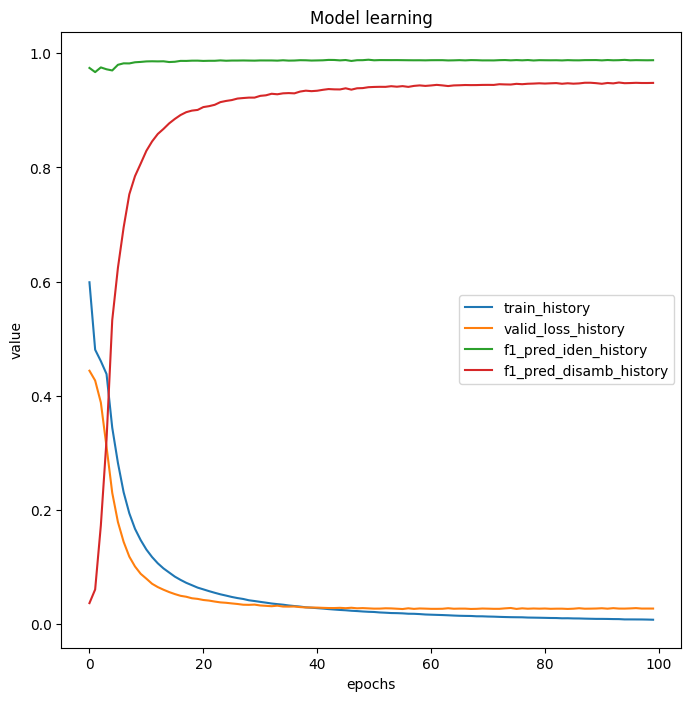

In [38]:
trainer_pid.display_history(history)

In [46]:
ssmpl = 2
print(dataset_dev_en_pid.data[ssmpl]['words'])
print(dataset_dev_en_pid.data[ssmpl]['predicates'])

['The', 'anniversary', 'is', 'also', 'commemorated', 'in', 'Turkey', 'and', 'the', 'United', 'Kingdom', '.']
['_', '_', '_', '_', 'CELEBRATE_PARTY', '_', '_', '_', '_', '_', '_', '_']


In [47]:
print(model_pid.predict([dataset_dev_en_pid.data[ssmpl]['words']])[0])

['_', '_', '_', '_', 'CELEBRATE_PARTY', '_', '_', '_', '_', '_', '_', '_']


## Training the Predicate Identification and Disambiguation model with also the nominal part

In [7]:
split_type = ''

In [8]:
dataset_train_en_pid = DatasetNoUniteD(  srl_dataset_dict_paths['EN']['train'], split_predicates=False, split_type_to_use = split_type )
dataset_dev_en_pid = DatasetNoUniteD(  srl_dataset_dict_paths['EN']['dev'], split_predicates=False, split_type_to_use = split_type )

In [10]:
from torch.utils.data import DataLoader

dataloader_train_en_pid = DataLoader(
    dataset_train_en_pid,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_en_pid.create_collate_fn(), 
    shuffle=True,
)

dataloader_dev_en_pid = DataLoader(
    dataset_dev_en_pid,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_en_pid.create_collate_fn(),
    shuffle=False,
)

In [11]:
for e in dataloader_dev_en_pid:
    ex_in = e
    break

In [12]:
smpl = 1
print(
    ex_in['words'][smpl], '\n', 
    ex_in['predicates'][smpl], '\n', 
    ex_in['predicates_positions'][smpl])

['Since', '1916', 'the', 'anniversary', 'of', 'the', 'landings', 'on', '25', 'April', 'has', 'been', 'commemorated', 'as', 'Anzac', 'Day', ',', 'becoming', 'one', 'of', 'the', 'most', 'important', 'national', 'celebrations', 'in', 'Australia', 'and', 'New', 'Zealand', '.'] 
 ['_', '_', '_', '_', '_', '_', 'LAND_GET-OFF', '_', '_', '_', '_', '_', 'CELEBRATE_PARTY', '_', '_', '_', '_', 'CHANGE_SWITCH', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'] 
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [18]:
loss_function_pid = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en_pid.predicates_pad_id) # !

In [19]:
from code_files.models.model_pid import ModelPID
from code_files.utils.utils_functions import print_summary
import torch.optim as optim

model_pid = ModelPID(
    loss_fn = loss_function_pid,
    hparams = global_params,
    fine_tune_transformer = True,
    has_predicates_positions = False # it does both pred iden and disamb
)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
optimizer_pid = optim.SGD(model_pid.parameters(), lr=0.0016, momentum=0.9) 

In [21]:
print_summary(model_pid, short=True)

parameters: 278,376,625
trainable parameters: 278,376,625
non-trainable parameters: 0


In [22]:
history = {}

In [23]:
from code_files.utils.Trainer_pid import Trainer_pid

trainer_pid = Trainer_pid()

history = trainer_pid.train(
    model_pid, optimizer_pid, dataloader_train_en_pid, dataloader_dev_en_pid,
    epochs=100, device=device,
    save_best=True, 
    min_score=0.8,
    save_path_name=os.path.join(model_dir_path, f'pid_transformer_nounited{split_type}.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.759375
# Validation loss => 0.571378 | f1-score: pred_iden = 0.834179 pred_dis = 0.041878 #
Epoch   1 => avg_loss: 0.586060
# Validation loss => 0.464013 | f1-score: pred_iden = 0.927856 pred_dis = 0.214377 #
Epoch   2 => avg_loss: 0.465709
# Validation loss => 0.307987 | f1-score: pred_iden = 0.921221 pred_dis = 0.556011 #
Epoch   3 => avg_loss: 0.353822
# Validation loss => 0.223206 | f1-score: pred_iden = 0.946084 pred_dis = 0.675380 #
Epoch   4 => avg_loss: 0.280915
# Validation loss => 0.175970 | f1-score: pred_iden = 0.954865 pred_dis = 0.741597 #
Epoch   5 => avg_loss: 0.233377
# Validation loss => 0.145834 | f1-score: pred_iden = 0.958740 pred_dis = 0.778079 #
Epoch   6 => avg_loss: 0.201439
# Validation loss => 0.125462 | f1-score: pred_iden = 0.958947 pred_dis = 0.809630 #
----- Best value obtained, saving model -----
Epoch   7 => avg_loss: 0.177146
# Validation loss => 0.112027 | f1-score: pred_iden = 0.960949 pred_dis = 0.822222 #
----- Best value o

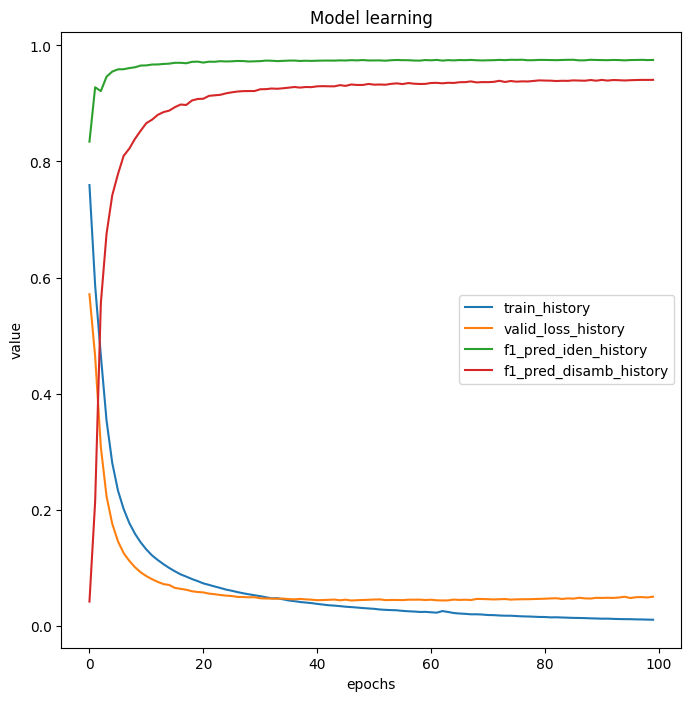

In [24]:
trainer_pid.display_history(history)

In [29]:
ssmpl = 3
print(dataset_dev_en_pid.data[ssmpl]['words'])
print(dataset_dev_en_pid.data[ssmpl]['predicates'])

['The', 'Penukonda', 'train', 'collision', 'occurred', 'in', 'the', 'early', 'hours', 'of', '22', 'May', '2012', ',', 'when', 'the', 'Bangalore', 'bound', 'Hampi', 'Express', 'crashed', 'into', 'a', 'stationary', 'freight', 'train', 'near', 'Penukonda', ',', 'in', 'the', 'Indian', 'state', 'of', 'Andhra', 'Pradesh', '.']
['_', '_', '_', 'HIT', 'HAPPEN_OCCUR', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'BREAK_DETERIORATE', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']


In [30]:
print(model_pid.predict([dataset_dev_en_pid.data[ssmpl]['words']])[0])

['_', '_', '_', 'HIT', 'HAPPEN_OCCUR', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'BREAK_DETERIORATE', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']


# Argument Identification and Classification

## Training the Argument Identification and Classification model

Currently, in the NoUniteD dataset there are only roles associated with verbal synsets: this means that this part of the training will use only the verbal part

In [12]:
split_type = '_v'
max_length_train = None

In [13]:
dataset_train_en_aic = DatasetNoUniteD(  
    srl_dataset_dict_paths['EN']['train'], 
    split_predicates=True, 
    split_type_to_use = split_type, 
    max_length = max_length_train, 
    shuffle = max_length_train != None )
    
dataset_dev_en_aic = DatasetNoUniteD(  
    srl_dataset_dict_paths['EN']['dev'], 
    split_predicates=True, 
    split_type_to_use = split_type, 
    max_length = int(max_length_train*0.2) if max_length_train != None else max_length_train, 
    shuffle = max_length_train != None )

In [15]:
len(dataset_train_en_aic.data), len(dataset_dev_en_aic.data)

(57749, 12558)

In [16]:
print(dataset_train_en_aic[0],'\n\n',dataset_dev_en_aic[0])

{'words': ['The', '2006', 'Pangandaran', 'earthquake', 'and', 'tsunami', 'occurred', 'on', 'July', '17', 'at', 'along', 'a', 'subduction', 'zone', 'off', 'the', 'coast', 'of', 'west', 'and', 'central', 'Java', ',', 'a', 'large', 'and', 'densely', 'populated', 'island', 'in', 'the', 'Indonesian', 'archipelago', '.'], 'predicates': ['_', '_', '_', '_', '_', '_', 'HAPPEN_OCCUR', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 'predicates_v': ['_', '_', '_', '_', '_', '_', 'HAPPEN_OCCUR', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 'predicates_n': ['_', '_', '_', 'MOVE-ONESELF', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 'roles': ['_', '_', '_', 'Theme', '_', '_', '_', '_', '_', '_', '_', '_'

In [17]:
from torch.utils.data import DataLoader

dataloader_train_en_aic = DataLoader(
    dataset_train_en_aic,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_en_aic.create_collate_fn(),
    shuffle=True,
)

dataloader_dev_en_aic = DataLoader(
    dataset_dev_en_aic,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_en_aic.create_collate_fn(),
    shuffle=False,
)

In [21]:
for ex_in in dataloader_dev_en_aic:
    break

In [22]:
smpl_idx = 11
print(ex_in['words'][smpl_idx], '\n', ex_in['predicate_name'][smpl_idx], ex_in['predicate_word'][smpl_idx], '\n', ex_in['predicates_positions'][smpl_idx], '\n', ex_in['roles'][smpl_idx])

['Three', 'coaches', 'derailed', 'as', 'a', 'result', 'of', 'the', 'crash', 'while', 'another', 'caught', 'fire', '.'] 
 ['CATCH'] ['caught'] 
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] 
 ['_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'agent', '_', 'theme', '_']


In [23]:
loss_function_aic = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en_aic.predicates_pad_id) # !

In [24]:
from code_files.models.model_aic import ModelAIC
from code_files.utils.utils_functions import print_summary
import torch.optim as optim

model_aic = ModelAIC(
    loss_fn = loss_function_aic,
    hparams = global_params,
    fine_tune_transformer = True
)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
optimizer_aic = optim.SGD(model_aic.parameters(), lr=0.0016, momentum=0.9)

In [26]:
print_summary(model_aic, short=True)

parameters: 278,065,180
trainable parameters: 278,065,180
non-trainable parameters: 0


In [27]:
history = {}

In [28]:
from code_files.utils.Trainer_aic import Trainer_aic

trainer_aic = Trainer_aic()

history = trainer_aic.train(
    model_aic, optimizer_aic, dataloader_train_en_aic, dataloader_dev_en_aic,
    epochs=100, device=device,
    save_best=True, 
    min_score=0.877,
    save_path_name=os.path.join(model_dir_path, f'aic_transformer_nounited{split_type}.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.215891
# Validation loss => 0.137156 | f1-score: arg_iden = 0.886359 arg_class = 0.521095 #
Epoch   1 => avg_loss: 0.119081
# Validation loss => 0.100642 | f1-score: arg_iden = 0.913024 arg_class = 0.644978 #
Epoch   2 => avg_loss: 0.091073
# Validation loss => 0.075748 | f1-score: arg_iden = 0.924366 arg_class = 0.749352 #
Epoch   3 => avg_loss: 0.072509
# Validation loss => 0.063097 | f1-score: arg_iden = 0.926723 arg_class = 0.805621 #
Epoch   4 => avg_loss: 0.060977
# Validation loss => 0.053179 | f1-score: arg_iden = 0.933961 arg_class = 0.832661 #
Epoch   5 => avg_loss: 0.053109
# Validation loss => 0.045826 | f1-score: arg_iden = 0.938062 arg_class = 0.852080 #
Epoch   6 => avg_loss: 0.047720
# Validation loss => 0.046260 | f1-score: arg_iden = 0.938876 arg_class = 0.857571 #
Epoch   7 => avg_loss: 0.043383
# Validation loss => 0.042757 | f1-score: arg_iden = 0.938275 arg_class = 0.865181 #
Epoch   8 => avg_loss: 0.039919
# Validation loss => 0.040047 | 

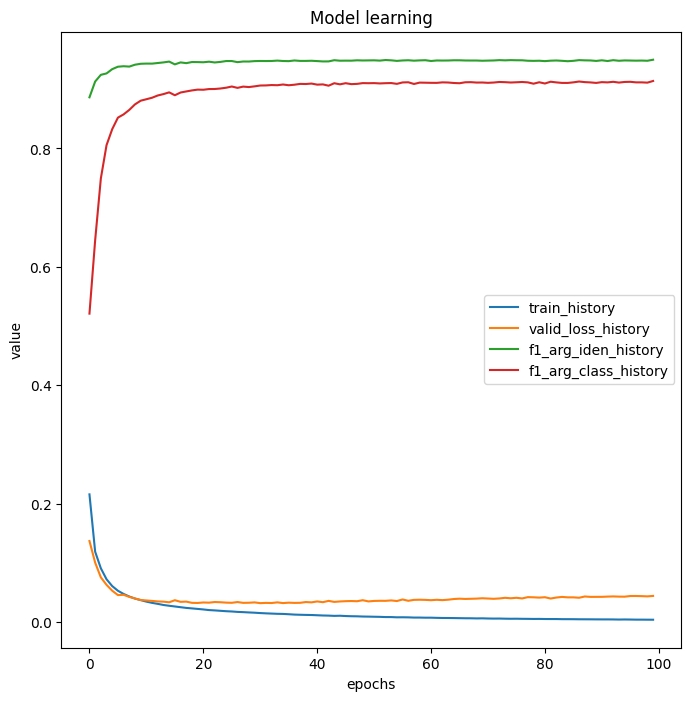

In [29]:
trainer_aic.display_history(history)

In [59]:
ssmpl = 3
print(dataset_dev_en_aic.data[ssmpl]['words'])
print(dataset_dev_en_aic.data[ssmpl]['predicate_name'], dataset_dev_en_aic.data[ssmpl]['predicate_word'])
print(dataset_dev_en_aic.data[ssmpl]['roles'])

['Since', '1916', 'the', 'anniversary', 'of', 'the', 'landings', 'on', '25', 'April', 'has', 'been', 'commemorated', 'as', 'Anzac', 'Day', ',', 'becoming', 'one', 'of', 'the', 'most', 'important', 'national', 'celebrations', 'in', 'Australia', 'and', 'New', 'Zealand', '.']
['CELEBRATE_PARTY'] ['commemorated']
['_', '_', '_', 'Theme', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'Attribute', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']


In [60]:
print( model_aic.predict([dataset_dev_en_aic.data[ssmpl]['words']], [dataset_dev_en_aic.data[ssmpl]['predicate_word']])[0] )

['_', '_', '_', 'theme', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'attribute', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']
